In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.models import Sequential
from keras import backend as K


from keras.models import load_model

import util

In [3]:
#CursoCoursera\csv_files
train_df = pd.read_csv("C:/Users/Matias/Documents/2020/2020-1/ECE/CursoCoursera/csv_files/train-small.csv")
#train_df = pd.read_csv("C:/Users/Matias/Documents/2020/2020-1/ECE/Proyecto/train.csv")

valid_df = pd.read_csv("C:/Users/Matias/Documents/2020/2020-1/ECE/CursoCoursera/csv_files/valid-small.csv")
#valid_df = pd.read_csv("C:/Users/Matias/Documents/2020/2020-1/ECE/Proyecto/valid.csv")

test_df = pd.read_csv("C:/Users/Matias/Documents/2020/2020-1/ECE/CursoCoursera/csv_files/test.csv")
#test_df = pd.read_csv("C:/Users/Matias/Documents/2020/2020-1/ECE/Proyecto/test.csv")

test_df.head()

,Image,PatientId,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00021463_005.png,21463,0,0,1,1,1,0,0,1,0,0,0,0,1,0
1,00019733_002.png,19733,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,00021463_001.png,21463,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00017136_020.png,17136,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,00027477_000.png,27477,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [4]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

Checking Data Leakage


In [5]:
def check_for_leakage(df1, df2, patient_col):
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])

    patients_in_both_groups = list(df2_patients_unique.intersection(df1_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    if len(patients_in_both_groups)>=1:
        leakage = True # boolean (true if there is at least 1 patient in both groups)
    elif len(patients_in_both_groups)==0:
        leakage = False

    return leakage

In [6]:
#print(set(train_df['PatientId']))
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, "PatientId")))

leakage between train and test: False
leakage between valid and test: False


Preparing Images

In [7]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [8]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [9]:
IMAGE_DIR = "C:/Users/Matias/Documents/2020/2020-1/ECE/Proyecto/Imagenes/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


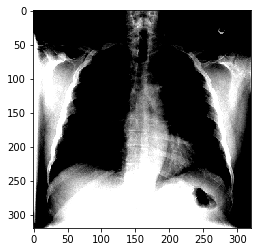

In [10]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

Imbalance de Clase

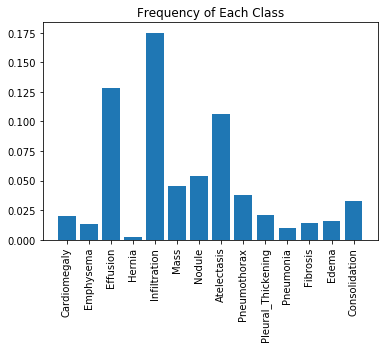

In [11]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [12]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels == 1,axis=0) / labels.shape[0]
    negative_frequencies = np.sum(labels == 0,axis=0) / labels.shape[0]

    return positive_frequencies, negative_frequencies


In [13]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos


array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

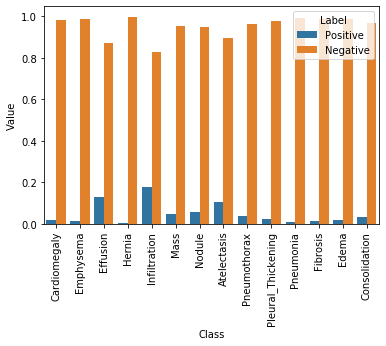

In [14]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)


La cantidad de casos positivos es mucho menor que la cantidad de casos negaticos. 
Eso es lo que se balanceara.

In [15]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights


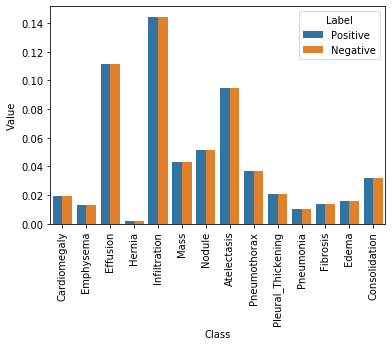

In [16]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [17]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        loss = 0.0
        for i in range(len(pos_weights)):
            loss += -(K.mean( pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) + \
                                neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon), axis = 0))
        return loss
    return weighted_loss


In [18]:
# create the base pre-trained model
base_model = DenseNet121(weights='C:/Users/Matias/Documents/2020/2020-1/ECE/Proyecto/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Epoch 1/3
100/100 [==============================] - 1025s 10s/step - loss: 0.9422 - val_loss: 15.0782
Epoch 2/3
100/100 [==============================] - 998s 10s/step - loss: 0.8619 - val_loss: 11.9582
Epoch 3/3
100/100 [==============================] - 1007s 10s/step - loss: 0.8839 - val_loss: 5.4055


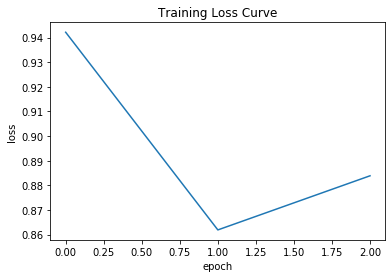

In [18]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [60]:
model.save('C:/Users/Matias/Documents/2020/2020-1/ECE/Proyecto/model')

In [21]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

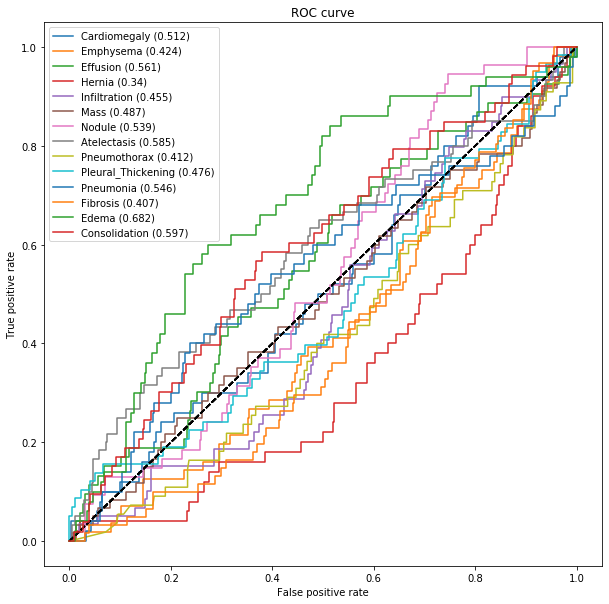

In [23]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

New model to identify Covid19

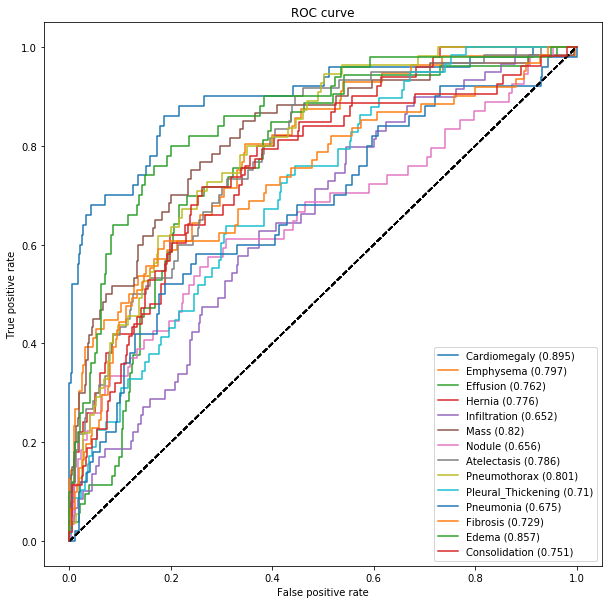

In [19]:
model.load_weights('C:/Users/Matias/Documents/2020/2020-1/ECE/Proyecto/pretrained_model.h5')
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
auc_rocs2 = util.get_roc_curve(labels, predicted_vals, test_generator)

In [ ]:
Se utiliza el modelo que se muestra arriba:

In [51]:
print("aa")
covid19_model = Sequential() 
#covid19_model.build();
#covid19_model.summary();

#print(model.layers[0].__class__)

#covid19_model.add(model.layers[1])

for layer in model.layers[:-2]: #just exclude the last two layers from base_model
    print("d")
    print(layer)
    covid19_model.add(layer)
    #i = i+1
    #print(i)
print("fin")

for layer in model.layers[:-2]:
    layer.trainable = False


aa
d


TypeError: can only concatenate list (not "InputLayer") to list

In [33]:
#model.summary()

In [32]:
print(len(model.layers))


429
